In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm
from scipy.stats import poisson
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

In [2]:
N_SIMS = 200
SHAPE = 2
SCALE = 0.5
REAL_PARS = np.random.gamma(SHAPE, SCALE, 40)

In [3]:
def simulate_games(real_pars, inx):
    games = dict()
    for i in range(1, 21):
        games[f'Clube {i}'] = dict()
        for j in range(1, 21):
            if i == j: continue
            home = np.random.poisson(real_pars[inx[f'Clube {i}']['Atk']] / real_pars[inx[f'Clube {j}']['Def']])
            away = np.random.poisson(real_pars[inx[f'Clube {j}']['Atk']] / real_pars[inx[f'Clube {i}']['Def']])
            games[f'Clube {i}'][f'Clube {j}'] = [home, away]

    return games

In [4]:
def likelihood(parameters, played_games, inx):
    lik = 0
    for home in played_games:
        for away in played_games[home]:
            result = played_games[home][away]
            inx_1, inx_2 = inx[home]['Atk'] - 1, inx[away]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu0 = 1 / parameters[inx_2]
            else: mu0 = parameters[inx_1] / parameters[inx_2]
            lik -= poisson.logpmf(result[0], mu0)

            inx_1, inx_2 = inx[away]['Atk'] - 1, inx[home]['Def'] - 1
            if parameters[inx_2] == 0: return np.inf
            if inx_1 == -1: mu1 = 1 / parameters[inx_2]
            else: mu1 = parameters[inx_1] / parameters[inx_2]
            lik -= poisson.logpmf(result[1], mu1)
    
    return lik

In [5]:
bounds = list()
inx = dict()
ind = 0
for i in range(1, 21):
    inx[f'Clube {i}'] = dict()
    inx[f'Clube {i}']['Atk'] = ind
    if ind != 0: bounds.append((0, None))
    ind += 1
    inx[f'Clube {i}']['Def'] = ind
    bounds.append((0, None))
    ind += 1

pars = REAL_PARS / REAL_PARS[0]
pars = pars[1:]

In [6]:
fun_values, lik_values, estimated_pars = list(), list(), list()
for sim in tqdm(range(N_SIMS)):
    games = simulate_games(REAL_PARS, inx)
    res = minimize(likelihood, np.random.random(2 * len(games) - 1),
                   args = (games, inx), bounds = bounds)

    fun_values.append(res.fun)
    estimated_pars.append(res.x)
    lik_values.append(likelihood(pars, games, inx))

100%|██████████| 200/200 [31:10<00:00,  9.35s/it] 


In [7]:
cols = list()
for i in range(1, 21):
    if i != 1: cols.append(f'Atk - clube {i}')
    cols.append(f'Def - clube {i}')

df = pd.DataFrame(np.array(estimated_pars), columns = cols).quantile([0.025, 0.975]).T
df['Real'] = pars
df['In interval'] = (df[0.025] < df['Real']).values * (df['Real'] < df[0.975]).values
print(f'Real values in confidence interval: {df.sum()["In interval"] / len(df):.2%}')

Real values in confidence interval: 43.59%


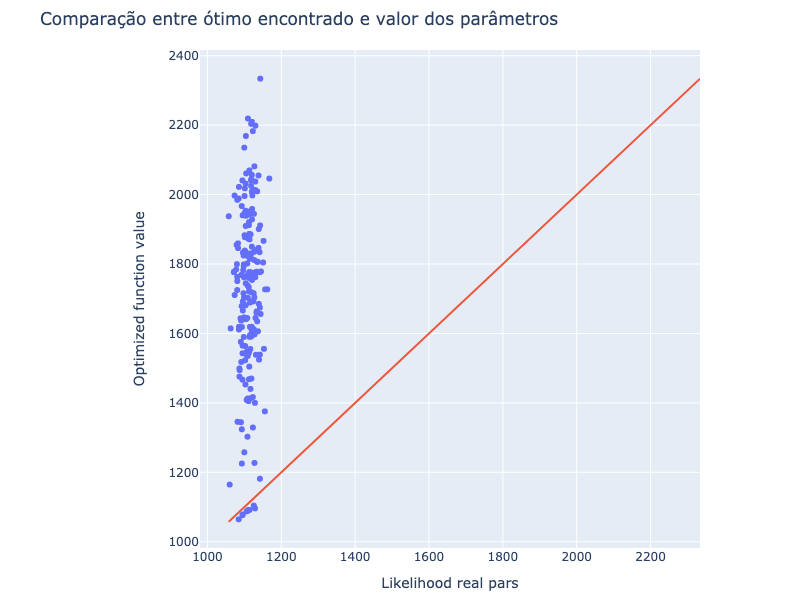

In [8]:
data = list()
data.append(go.Scatter(x = lik_values,
                       y = fun_values,
                       mode = 'markers'))

x_min = min(min(fun_values), min(lik_values))
x_max = max(max(fun_values), max(lik_values))
data.append(go.Scatter(x = [x_min, x_max],
                       y = [x_min, x_max],
                       mode = 'lines'))

layout = go.Layout(title = 'Comparação entre ótimo encontrado e valor dos parâmetros',
                   xaxis = dict(title = 'Likelihood real pars'),
                   yaxis = dict(title = 'Optimized function value'),
                   autosize = False,
                   width = 800,
                   height = 600,
                   margin = dict(l = 200, r = 100, b = 50, t = 50),
                   showlegend = False
                  )

fig = go.Figure(data, layout = layout)
fig.show('png')

In [9]:
mape = list()
pars = np.hstack([np.array([1]), pars])
real_pars_seq = list()
estimated_seq = list()
distance_from_real = list()
for forecast in estimated_pars:
    forecast = np.hstack([np.array([1]), forecast])
    mape.append(abs(1 - forecast / pars))
    estimated_seq += forecast.tolist()
    real_pars_seq += pars.tolist()
    distance_from_real.append(np.linalg.norm(pars - forecast))

mape = np.mean(mape, axis = 0)
home_pars_mape = np.mean(mape[::2])
away_pars_mape = np.mean(mape[1::2])
print(f'MAPE (parâmetros de ataque): {home_pars_mape:.4f}')
print(f'MAPE (parâmetros de defesa): {away_pars_mape:.4f}')

mape_df = pd.DataFrame(columns = ['Clube', 'MAPE'])
for club in range(20):
    mape_df.loc[len(mape_df)] = [f'Clube {club + 1}', np.mean(mape[2 * club : 2 * (club + 1)])]

pars = pars[1:]
mape_df

MAPE (parâmetros de ataque): 0.5556
MAPE (parâmetros de defesa): 0.5484


,Clube,MAPE
0,Clube 1,0.217588
1,Clube 2,0.463475
2,Clube 3,0.775406
3,Clube 4,0.466620
4,Clube 5,0.518341
5,Clube 6,0.438503
6,Clube 7,0.711732
7,Clube 8,0.477726
8,Clube 9,0.582288
9,Clube 10,0.684835


In [12]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = distance_from_real, nbinsx = 50))
fig.update_xaxes(title_text = "Valores", range = [0, np.ceil(max(distance_from_real))])
fig.update_xaxes(title_text = 'Distância entre os parâmetros reais e os estimados')
fig.update_layout(title = 'Distribuição da distância entre os parâmetros reais e os estimados')
fig.show()

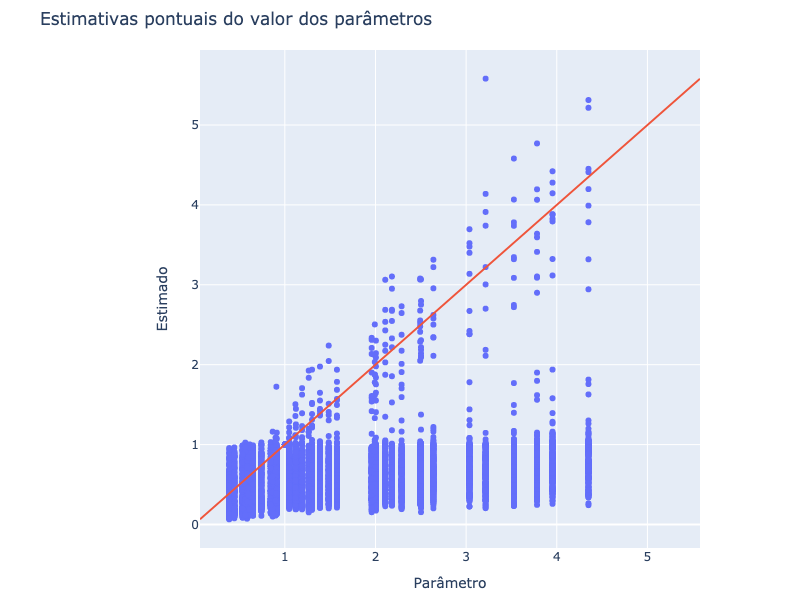

In [11]:
data = list()
data.append(go.Scatter(x = real_pars_seq,
                       y = estimated_seq,
                       mode = 'markers'))

x_min = min(min(estimated_seq), min(real_pars_seq))
x_max = max(max(estimated_seq), max(real_pars_seq))
data.append(go.Scatter(x = [x_min, x_max],
                       y = [x_min, x_max],
                       mode = 'lines'))

layout = go.Layout(title = 'Estimativas pontuais do valor dos parâmetros',
                   xaxis = dict(title = 'Parâmetro'),
                   yaxis = dict(title = 'Estimado'),
                   autosize = False,
                   width = 800,
                   height = 600,
                   margin = dict(l = 200, r = 100, b = 50, t = 50),
                   showlegend = False
                  )

fig = go.Figure(data, layout = layout)
fig.show('png')